In [5]:
import numpy as np
import pandas as pd
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
import affine_approx as af
import importlib
import scipy.stats
from scipy.stats import norm, chi2, wishart, beta, lognorm
import random

In [23]:
def kl_ca_conj(x):
    return(1-np.exp(-x))

def rk_eval(X,delta, phi_conj):
    n = len(X)
    som = 0
    X = np.sort(X)
    X_diff = np.concatenate((np.array([X[0]]),np.diff(X)))
    for i in range(n):
        som = som + phi_conj(delta*(n-i)/n)*X_diff[i]
    return(som/delta)

def sd(X):
    n = len(X)
    som = 0
    m = np.mean(X)
    for i in range(n):
        som = som + (X[i]-m)**2
    return(np.sqrt(som/n))

def miniance(X):
    n = len(X)
    som = 0
    X = np.sort(X)
    X_diff = np.concatenate((np.array([X[0]]),np.diff(X)))
    for i in range(n):
        som = som + ((n-i)/n)**2*X_diff[i]
    return(som)

def h_ddro(x,delta):
    teller = 1-np.exp(-delta*x)
    noemer = 1-np.exp(-delta)
    return(teller/noemer)


def argmax_kl_dtconj(x2,x1,delta):
    frac = (np.exp(-delta*x1)-np.exp(-delta*x2))/(x2-x1)
    return(-np.log(frac/delta)/delta)

def max_kl_dtconj(x2,x1,x,delta):
    frac = (h_ddro(x2,delta)-h_ddro(x1,delta))/(x2-x1)
    return(h_ddro(x,delta)-frac*(x-x1)-h_ddro(x1,delta))

def emp_likelihood_lb(X, r):
    n = len(X)
    theta = cp.Variable()
    lbda = cp.Variable(nonneg=True)
    s = cp.Variable(n, nonneg=True)
    constraints = [s == lbda - theta + X]
    f_obj = -cp.sum(cp.kl_div(lbda, s) + lbda - s)
    obj = cp.Maximize(f_obj / n + theta - lbda * r)
    prob = cp.Problem(obj, constraints)
    prob.solve()

    return prob.value


def emp_likelihood_ub(X, r):
    n = len(X)
    theta = cp.Variable()
    lbda = cp.Variable(nonneg=True)
    s = cp.Variable(n, nonneg=True)
    constraints = [s >= 0, s == lbda + theta - X]
    f_obj = cp.sum(cp.kl_div(lbda, s) + lbda - s)
    obj = cp.Minimize(f_obj / n + theta + lbda * r)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.MOSEK)

    return prob.value


def entropy_lb(X,r):
    n = len(X)
    theta = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    constraints = [theta-X <= -cp.kl_div(lbda,t)-lbda + t]
    #for i in range(n):
    #    constraints.append(theta - X[i] <= -cp.kl_div(lbda,t[i])-lbda + t[i])
    obj = cp.Maximize((1-r)*lbda + theta -cp.sum(t)/n)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)

def entropy_ub(X,r):
    n = len(X)
    theta = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    constraints = [X-theta <= -cp.kl_div(lbda,t)-lbda + t]
    #for i in range(n):
    #    constraints.append(X[i]-theta <= -cp.kl_div(lbda,t[i])-lbda + t[i])
    obj = cp.Minimize((r-1)*lbda + theta +cp.sum(t)/n)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)       
    

Sample mean of X: 7.474813253345048
Sample mean of Y: 7.4501709825557505
Sample sd of X: 5.961684185237363
Sample sd of Y: 3.2008245045814885
-0.00892557885572933
1.6990912177896913 1.8472949996483496
1.8499999999999996 12.85 7.35 7.25


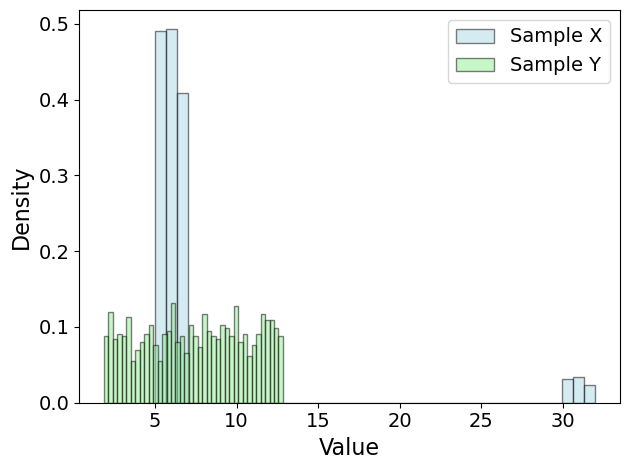

In [17]:
from scipy.stats import uniform

np.random.seed(2)
a_x, b_x = 5, 7  # Range for uniform part of Z
M = 25           # Constant value for Z
epsilon = 0.05    # Probability of taking value M
mean_x = (a_x+b_x)/2 +epsilon*M
a_z, b_z = (mean_x+0.1)-5.5, (mean_x+0.1)+5.5
# Generate samples
n_samples = 1000
X = np.random.uniform(a_x,b_x,size = n_samples)+np.random.binomial(1,epsilon,size = n_samples)*M

# Generate samples from Y (mixture distribution)
Y = np.random.uniform(a_z,b_z,size = n_samples) 

plt.hist(X, bins=40, density=True, alpha=0.5, color='lightblue', edgecolor='black', label=f'Sample X')
plt.hist(Y, bins=40, density=True, alpha=0.5, color='lightgreen', edgecolor='black', label=f'Sample Y')


plt.xlabel("Value", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig('dro_xy_dist.eps', format = 'eps')

# Output sample statistics
print(f"Sample mean of X: {np.mean(X)}")
print(f"Sample mean of Y: {np.mean(Y)}")
print(f"Sample sd of X: {np.sqrt(np.var(X))}")
print(f"Sample sd of Y: {np.sqrt(np.var(Y))}")
print((np.mean(Y)-np.mean(X))/(np.sqrt(np.var(X))-np.sqrt(np.var(Y))))
print(np.mean(X)-miniance(X), np.mean(Y)-miniance(Y))
print(a_z,b_z,(a_z+b_z)/2, mean_x)